# This notebook contains preliminary results

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from tabulate import tabulate
from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess_baseline import (reference_sentences,
                                           calculate_iki_and_ed_baseline,
                                           calculate_all_baseline_ROC_curves,
                                           convert_df_to_subject_level,
                                           get_X_and_y_from_df,
                                           test_different_splits_for_classification)

from haberrspd.plotting import plot_roc_curve_simple, plot_superimposed_roc_curves, nice_fonts
import pandas as pd
import numpy as np

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib as mpl
import matplotlib.pyplot as plt


# Settings for plotting

# plt.style.use('dark_background')
# Set to default again
# plt.rcParams.update(plt.rcParamsDefault)
# mpl.rcParams.update(nice_fonts)

# Baseline classifiers

## MJFF [sentence level]

In [18]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

In [19]:
which_attempt = 1

df_baselines_raw = calculate_iki_and_ed_baseline(df=df,
                                                 df_meta=df_meta,
                                                 drop_shift=False,
                                                 attempt=which_attempt,
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df=df,
                                                    df_meta=df_meta,
                                                    drop_shift=False,
                                                    attempt=which_attempt,
                                                    invokation_type=1) # Error corrections have been made

MJFF
MJFF


In [25]:
print(tabulate(df_baselines_raw[(df_baselines_raw.Diagnosis == 0)].describe(),tablefmt="grid", headers='keys'))

+-------+---------------+-------------+------------+-----------+-----------------+
|       |   Sentence_ID |   Diagnosis |   Mean_IKI |   Var_IKI |   Edit_Distance |
+=======+===============+=============+============+===========+=================+
| count |     741       |         741 |    741     |    741    |        741      |
+-------+---------------+-------------+------------+-----------+-----------------+
| mean  |      61.9811  |           0 |    314.472 |  63608.4  |        105.71   |
+-------+---------------+-------------+------------+-----------+-----------------+
| std   |       4.32525 |           0 |    101.504 |  39685.5  |         99.1941 |
+-------+---------------+-------------+------------+-----------+-----------------+
| min   |      55       |           0 |    120.333 |   2696.31 |          0      |
+-------+---------------+-------------+------------+-----------+-----------------+
| 25%   |      58       |           0 |    239.92  |  35593.8  |         54      |
+---

In [ ]:
print(df_baselines_raw.Edit_Distance.var())
print(df_baselines_edited.Edit_Distance.var())

out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [ ]:
plot_superimposed_roc_curves([out1,out2],
                             'mjff_attempt_' + str(which_attempt) +'_sentence_level_rfc')

## MRC [sentence level]

To do:

1. Re-calculate the raw MRC data to remove duplicate entries (i.e. only one response ID per (participant, sentence ID) -- *keep the smallest one*
    - Re-pickle all the files for MRC as they are not correct as it stands.
    - Upload new raw data to the google drive
2. Re-do all the results for MRC including sentence level and participant level
3. If (1) is done then it should be possible to run the (keydown, keyup) sorting properly

In [47]:
# TODO: this needs to be redone with the new MRC data
# df = pd.read_pickle(Path('../data/MRC/') / 'processed_mcr.pkl')

#### In this setting we drop all shift keys

In [28]:
df_baselines_raw = calculate_iki_and_ed_baseline(df, 
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(Path('../data/MRC/') / 'processed_mcr.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df, 
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

MRC

 Number of shift-rows dropped: 17239
MRC

 Number of shift-rows dropped: 17239


In [30]:
print(tabulate(df_baselines_raw[(df_baselines_raw.Diagnosis == 1)].describe(),tablefmt="grid", headers='keys'))

+-------+--------------+---------------+-------------+------------+-----------+-----------------+
|       |   Patient_ID |   Sentence_ID |   Diagnosis |   Mean_IKI |   Var_IKI |   Edit_Distance |
+=======+==============+===============+=============+============+===========+=================+
| count |    1170      |    1170       |        1170 |  1170      |   1170    |       1170      |
+-------+--------------+---------------+-------------+------------+-----------+-----------------+
| mean  |      66.4145 |       7.97009 |           1 |   133.795  |  10489.8  |         19.2684 |
+-------+--------------+---------------+-------------+------------+-----------+-----------------+
| std   |      30.4762 |       4.33025 |           0 |    32.1316 |   5550.47 |         52.8687 |
+-------+--------------+---------------+-------------+------------+-----------+-----------------+
| min   |      11      |       1       |           1 |    61.1969 |   1864.11 |          2      |
+-------+-----------

In [5]:
out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

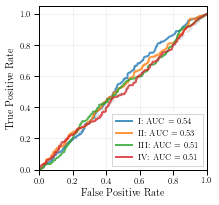

In [6]:
# For reasons unknown we can only run this once...
plot_superimposed_roc_curves([out1,out2])
#,'mrc_with_dropped_shift_keys_sentence_level')

#### We keep the shift key

In [3]:
df_baselines_raw = calculate_iki_and_ed_baseline(df, 
                                                 drop_shift=False, 
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df, 
                                                    drop_shift=False,
                                                    invokation_type=1) # Error corrections have been made
print("\n")
print(df_baselines_raw.Edit_Distance.var())
print(df_baselines_edited.Edit_Distance.var())



1617.9119039114323
1448.7902075648155


In [4]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw)
b = calculate_all_baseline_ROC_curves(df_baselines_edited)

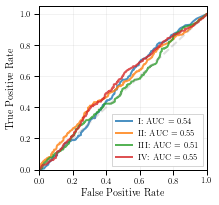

In [5]:
plot_superimposed_roc_curves([a,b])
#,'mrc_shift_keys_kept_sentence_level')

In [17]:
df_baselines_raw.describe()

,Patient_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI,Edit_Distance
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000
mean,694.990461,7.971053,0.384868,128.687839,10493.534257,21.282566
std,498.995145,4.321615,0.486644,33.443949,5872.550518,40.223276
min,11.000000,1.000000,0.000000,1.061829,108.347822,3.000000
25%,84.000000,4.000000,0.000000,104.513627,6365.009435,9.000000
50%,1038.000000,8.000000,0.000000,125.694547,9328.329342,14.000000
75%,1099.000000,12.000000,1.000000,146.872851,12974.549985,22.000000
max,1167.000000,15.000000,1.000000,268.128680,49393.853783,1555.000000


### MJFF [subject level]

In [ ]:
df_baselines_raw.head()

In [ ]:
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j,test_different_splits_for_classification(outs[j]))

### MRC [subject level]

In [6]:
df_baselines_raw.groupby(["Patient_ID", "Diagnosis"]).Edit_Distance.apply(list)

Patient_ID  Diagnosis
11          1            [10, 14, 8, 26, 18, 34, 16, 7, 24, 22, 8, 19, ...
12          1                                             [146, 18, 8, 14]
13          1            [5, 20, 22, 33, 6, 9, 32, 44, 39, 25, 32, 15, ...
17          1            [11, 4, 23, 15, 10, 6, 8, 4, 4, 3, 2, 10, 25, ...
18          1            [5, 5, 4, 21, 2, 11, 8, 4, 6, 3, 142, 7, 3, 4,...
                                               ...                        
1162        0            [17, 11, 4, 12, 5, 11, 4, 26, 12, 6, 7, 5, 7, ...
1163        0                [7, 9, 3, 4, 7, 4, 2, 9, 5, 5, 8, 8, 8, 2, 4]
1165        0                [5, 9, 8, 4, 9, 4, 14, 20, 9, 4, 7, 10, 8, 4]
1166        0                [4, 7, 2, 4, 5, 7, 6, 9, 2, 7, 5, 6, 7, 9, 3]
1167        0            [16, 12, 17, 7, 7, 6, 12, 18, 5, 6, 9, 87, 24,...
Name: Edit_Distance, Length: 213, dtype: object

In [9]:
df_baselines_raw.columns

Index(['Patient_ID', 'Sentence_ID', 'Diagnosis', 'Mean_IKI', 'Var_IKI',
       'Edit_Distance'],
      dtype='object')

In [10]:
set(["Edit_Distance", "Mean_IKI", "Diagnosis"]).issubset(df_baselines_raw.columns)

True

In [62]:
def get_X_and_y_from_df(df):

    measures = ["Edit_Distance", "Mean_IKI", "Diagnosis"]
    # assert set(measures).issubset(df.columns)
    features = ["Mean_IKI", ["Edit_Distance", "Mean_IKI"]]

    # Store all results in a dict which will be passed to plotting
    sets = {"I": None, "II": None}
    # assert len(sets) == len(features)
    for i, j in zip(features, sets.keys()):
        
        # List of features
        if isinstance(i, list):
            assert len(i) == 2
            X = []
            for k in range(df.shape[0]):
                X.append(df.loc[k,i[0]] + df.loc[k,i[1]])
            X = np.vstack(X)
            
        # Singular feature
        else:
            X = np.vstack(df[i])

        # targets
        y = df.Diagnosis.to_numpy()

        sets[j] = (X, y)

    return sets

In [42]:
part = convert_df_to_subject_level(df_baselines_raw)

In [56]:
part

,Patient_ID,Diagnosis,Edit_Distance,Mean_IKI
0,11,1,"[14, 17, 11, 67, 19, 63, 24, 8, 25, 25, 9, 25,...","[107.33910732023115, 124.16242803839438, 102.6..."
1,12,1,"[182, 19, 14, 96, 57, 57, 57, 57, 57, 57, 57, ...","[256.58397215802074, 268.1286797194493, 231.27..."
2,13,1,"[9, 23, 26, 39, 7, 13, 45, 45, 44, 26, 38, 17,...","[100.08992276160843, 104.50915459923566, 112.7..."
3,17,1,"[16, 7, 26, 21, 11, 10, 15, 5, 5, 6, 3, 16, 27...","[75.61996503500716, 67.0433606182455, 80.92298..."
4,18,1,"[9, 8, 7, 28, 3, 15, 15, 5, 7, 6, 144, 13, 5, ...","[133.10852713178295, 125.29533726320778, 117.7..."
...,...,...,...,...
208,1162,0,"[22, 63, 5, 15, 9, 24, 5, 35, 13, 10, 12, 6, 1...","[130.579565843196, 107.2675966850774, 117.9727..."
209,1163,0,"[10, 25, 4, 7, 34, 14, 3, 16, 6, 19, 15, 22, 8...","[170.92024733280192, 155.2158300978317, 160.67..."
210,1165,0,"[8, 14, 9, 7, 12, 7, 15, 27, 10, 7, 11, 11, 9,...","[83.46406042763212, 102.56570866162197, 98.502..."
211,1166,0,"[7, 13, 3, 7, 9, 10, 7, 16, 3, 11, 18, 10, 16,...","[108.21858389219528, 126.12045596683227, 109.9..."


In [63]:
# out = convert_df_to_subject_level(df_baselines_raw)
outs = get_X_and_y_from_df(part)

In [68]:
# We use the version with shift keys kept
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j, test_different_splits_for_classification(outs[j]))

I (0.791, 0.047)
II (0.947, 0.027)
I (0.789, 0.062)
II (0.976, 0.016)


# Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [ ]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

In [ ]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

In [ ]:
plot_roc_curve_simple(char[200][:,0].astype(np.int64), char[200][:,1],'mjff_char_only')

# CHARACTERS and TIME

In [ ]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

In [ ]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time[200][:,0].astype(np.int64), char_time[200][:,1],'mjff_char_time')

# CHARACTERS and TIME and Space

In [ ]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}

In [ ]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time_space[500][:,0].astype(np.int64), char_time_space[500][:,1],'mjff_char_time_space')

In [ ]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [ ]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

In [ ]:
# Detailed look at the "winning model"
df.iloc[387,:]